In [1]:
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')

# Let's load the dataset from previos step - after feature engeneering

In [2]:
import pandas as pd
import numpy as np
import seaborn as sb


df_mt = pd.read_pickle("IntermidiateData/4_FeatureEngeneering_Cancer_Data.pkl")

# Setting proportion for Train, Test, Dev

As seen before (in EDA notebook) , the data outcomes in this dataset is balanced  (40% percent malignant vs 60% bening).
So we can straight continue to data splitting from here

In [3]:
from sklearn.model_selection import train_test_split

# Assuming df_model is already defined and contains the necessary features and target variable

# Define the target and feature set
X = df_mt.drop(columns=['diagnosis'])
y = df_mt['diagnosis']

# Convert the target variable to boolean to prevent error when using mix of continuous and binary targets with linear classfier
#y = y.astype(bool)
# Total number of samples
total_samples = len(df_mt)

# Using cross validation with X_train so no need for validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#y_train = y_train.astype(bool)
#y_test = y_test.astype(bool)

# First split: training and temporary (test + dev)
# X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
# y_temp = y_temp.astype(bool)
# Second split: testing and development (dev)
# X_dev, X_test, y_dev, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
# y_dev = y_dev.astype(bool)
# y_test = y_test.astype(bool)

# Calculate percentages
train_percent = (X_train.shape[0] / total_samples) * 100
#dev_percent = (X_dev.shape[0] / total_samples) * 100
test_percent = (X_test.shape[0] / total_samples) * 100

# Output the sizes of each set in percentages
print(f"Training set size: {train_percent:.2f}%")
#print(f"Validation (Dev) set size: {dev_percent:.2f}%")
print(f"Testing set size: {test_percent:.2f}%")


Training set size: 79.96%
Testing set size: 20.04%


# Hyperparameter tuning for the models suitable for binaru classification tasks with GridSearchCV and cross-validation

In [4]:
# Hyperparameter tuning for the models with GridSearchCV

from sklearn.model_selection import GridSearchCV ,KFold, cross_val_score
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay , classification_report, accuracy_score
import xgboost as xgb

results = []
names = []
best_params = []
models = []
# with k-fold cross validation
# most important scoring = 'recall' since we are interested in minimizing false negatives (i.e. interested in predicting positive class precisely)
# as we also interested in mazimizing true negatives we can use f1 score
def estimator_function(models_opt, X , y , scoring = 'f1'):
    
    for name, model, params in models_opt:
        print(name , model , params) 
        # with k-fold single training set is split into k smaller sets so we don't need extra validation set and can keep test set for final evaluation
        # and also avoid overfit by training repeatedly on different train subsets
        kfold = KFold(n_splits=5, random_state=42, shuffle=True)
        #use all available cores to speed up the process
        grid_search = GridSearchCV(model, params,cv = kfold, refit = True , scoring=scoring, verbose=1, n_jobs=-1)       
        grid_search.fit(X, y)
        best_params.append(grid_search.best_params_)         
        results.append(grid_search.best_score_)
        names.append(name)
        models.append(model)
        
        
    return names, results , best_params , models


In [5]:
# Here we define the models to be used for binary classification of the data
# and parameters for hyperparameter tuning using GridSearchCV and k-fold cross validation
SVM_params = {'C':[0.001, 0.1, 10, 100], 'kernel':['rbf' ,'linear', 'poly', 'sigmoid']}   # support vector machine
RF_params = {'n_estimators':[10, 100, 1000], 'max_features':['sqrt', 'log2']}       # random forest
KNN_params = {'n_neighbors':[3, 5, 7, 9, 11], 'weights':['uniform', 'distance']}    # k-nearest neighbors
DTC_params = {'criterion':['entropy', 'gini'], 'max_depth':[10, 50, 100]}    # decision tree classifier 
LR_params = {'C':[0.001, 0.1, 1, 10, 100]}                                   # logistic regression  
GB_params = {'n_estimators':[50, 100, 500], 'learning_rate':[0.01, 0.1, 1]}  # gradient boosting classifier
AdaBoostClassifier_params = {'n_estimators':[50, 100, 500], 'learning_rate':[0.01, 0.1, 1]}  # AdaBoost classifier
XGBClassifier_params = {'n_estimators':[50, 100, 500], 'learning_rate':[0.01, 0.1, 1]}  # XGBoost classifier

svm = SVC()
rfc = RandomForestClassifier()
knn = KNeighborsClassifier()
dtc = DecisionTreeClassifier()
lr = LogisticRegression()
gbc = GradientBoostingClassifier()
adac = AdaBoostClassifier()
xgboostc = xgb.XGBClassifier()
gnb = GaussianNB()

# Create a list of models to tune
models_to_tune = [
    ('SVM', svm, SVM_params),
    ('RF', rfc, RF_params),
    ('KNN', knn, KNN_params),
    ('DTC', dtc, DTC_params),
    ('LR', lr, LR_params),
    ('GB', gbc, GB_params),
    ('AdaBoostClassifier', adac, AdaBoostClassifier_params),
    ('XGBClassifier', xgboostc, XGBClassifier_params),
    ('GaussianNB', gnb, {})]
 

In [6]:
names, results , best_params , models  = estimator_function(models_to_tune, X_train , y_train  )

SVM SVC() {'C': [0.001, 0.1, 10, 100], 'kernel': ['rbf', 'linear', 'poly', 'sigmoid']}
Fitting 5 folds for each of 16 candidates, totalling 80 fits
RF RandomForestClassifier() {'n_estimators': [10, 100, 1000], 'max_features': ['sqrt', 'log2']}
Fitting 5 folds for each of 6 candidates, totalling 30 fits
KNN KNeighborsClassifier() {'n_neighbors': [3, 5, 7, 9, 11], 'weights': ['uniform', 'distance']}
Fitting 5 folds for each of 10 candidates, totalling 50 fits
DTC DecisionTreeClassifier() {'criterion': ['entropy', 'gini'], 'max_depth': [10, 50, 100]}
Fitting 5 folds for each of 6 candidates, totalling 30 fits
LR LogisticRegression() {'C': [0.001, 0.1, 1, 10, 100]}
Fitting 5 folds for each of 5 candidates, totalling 25 fits


/home/lmanov/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/lmanov/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

GB GradientBoostingClassifier() {'n_estimators': [50, 100, 500], 'learning_rate': [0.01, 0.1, 1]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits
AdaBoostClassifier AdaBoostClassifier() {'n_estimators': [50, 100, 500], 'learning_rate': [0.01, 0.1, 1]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits


/home/lmanov/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/lmanov/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/lmanov/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/lmanov/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  war

XGBClassifier XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None,
              reg_alpha=None, reg_lambda=None, ...) {'n_estimators': [50, 100, 500], 'learning_rate': [0.01, 0.1, 1]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits
GaussianNB GaussianNB() {}
Fitting 5 folds for each of 1 candidates, totalling 5 fits


# Assess models scores on predicting (on test dataset) , summarize data from the hyperparameter tuning step and achieved scores  into the tables

In [15]:

hyperparameter_tuning_scores_df = pd.DataFrame()
model_params_df = pd.DataFrame()
model_objects_dict = {}

for name, cv_result , param , model    in zip(names, results, best_params , models):        
        # handle the results (cross-validation scores)
        dict = {'Model': name, 'Mean score': cv_result.mean().round(3), 'Score Standard Deviation': cv_result.std().round(3)}
        row = pd.DataFrame([dict])             
        # append the results to the hyperparameter_tuning_scores_df    
        hyperparameter_tuning_scores_df = pd.concat([hyperparameter_tuning_scores_df, row], axis=0)   
        # handle the best parameters from the grid search
        best_param_dict = {'Model': name, 'Best params': [param]}      
        # convert the dictionary to a DataFrame
        best_param_row = pd.DataFrame(best_param_dict)    
        # append the best parameters to the model_params_df
        model_params_df = pd.concat([model_params_df , best_param_row], axis=0)
        # store the model object in a dictionary for subsequent use
        model_objects_dict[name] = model

hyperparameter_tuning_scores_df.reset_index(drop=True, inplace=True)
hyperparameter_tuning_scores_df.set_index('Model', inplace=True)
hyperparameter_tuning_scores_df.sort_values(by='Mean score', ascending=False, inplace=True)
hyperparameter_tuning_scores_df.to_pickle('IntermidiateData/5_Hyperparameter_Tuning_Results.pkl')
model_params_df.set_index('Model', inplace=True)
model_params_df.to_pickle('IntermidiateData/5_Model_Best_Params.pkl')


In [8]:
display("Using F1 score as the scoring metric, the hyperparameter tuning results for the models are as follows:")
display(hyperparameter_tuning_scores_df.sort_values(by='Mean score', ascending=False))
display(model_params_df)
#display(model_objects_dict)

'Using F1 score as the scoring metric, the hyperparameter tuning results for the models are as follows:'

,Mean score,Score Standard Deviation
Model,,
AdaBoostClassifier,0.939,0.0
SVM,0.936,0.0
RF,0.928,0.0
XGBClassifier,0.924,0.0
LR,0.918,0.0
GB,0.917,0.0
GaussianNB,0.896,0.0
DTC,0.895,0.0
KNN,0.889,0.0


,Best params
Model,
SVM,"{'C': 100, 'kernel': 'linear'}"
RF,"{'max_features': 'log2', 'n_estimators': 100}"
KNN,"{'n_neighbors': 11, 'weights': 'distance'}"
DTC,"{'criterion': 'entropy', 'max_depth': 100}"
LR,{'C': 10}
GB,"{'learning_rate': 0.1, 'n_estimators': 100}"
AdaBoostClassifier,"{'learning_rate': 0.1, 'n_estimators': 50}"
XGBClassifier,"{'learning_rate': 1, 'n_estimators': 50}"
GaussianNB,{}


In [9]:
# prepare code  measuring performance of the models
from sklearn import metrics

def classificationMetrics(y, yhat):
    res = {'Accuracy': metrics.accuracy_score(y,yhat),
           'Precision': metrics.precision_score(y,yhat),
           'Recall': metrics.recall_score(y,yhat),
           'F1': metrics.f1_score(y,yhat),
           'AUC': metrics.roc_auc_score(y,yhat)
          }
    return res

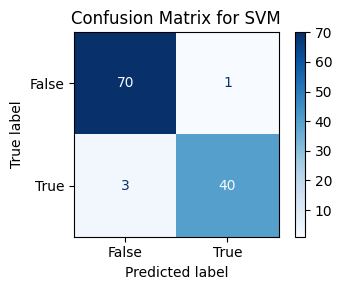

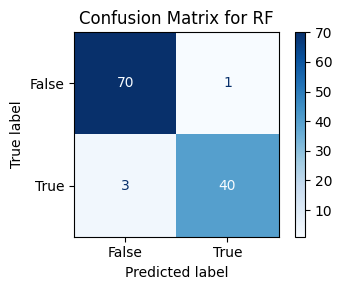

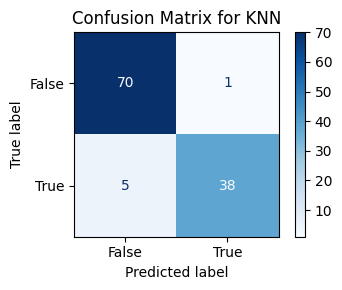

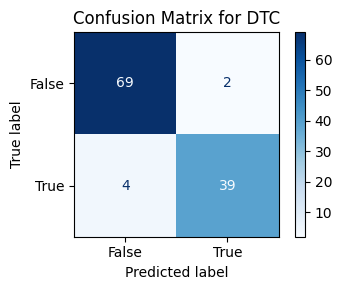

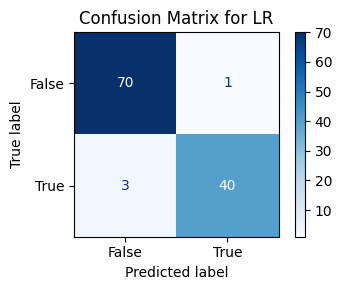

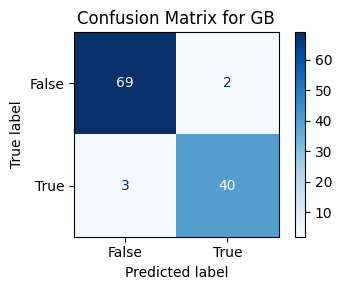

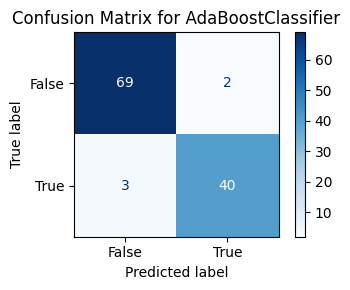

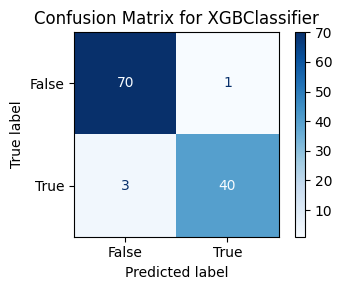

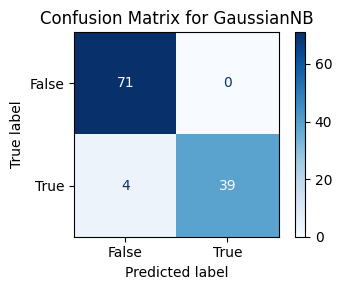

In [12]:
import matplotlib.pyplot as plt
models_perfmance = pd.DataFrame()

def test_model(model , model_name, X , y):

    global models_perfmance  # Declare models_perfmance as a global variable    
    lrtest_pred = model.predict(X)             
    mod1_dict = {'Model': model_name}
    new_row = pd.DataFrame([{**mod1_dict, **classificationMetrics(y, lrtest_pred) }])
    models_perfmance = pd.concat([models_perfmance, new_row], ignore_index=True)    
    cm = confusion_matrix(y, lrtest_pred)      
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['False', 'True'])
    disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
    disp.ax_.set_title(f"Confusion Matrix for {model_name}")
    plt.rcParams['figure.figsize'] = [4, 3]
    plt.tight_layout()
    plt.show()
    

# tests different models with best parameters from hyperparameter tuning
for model_name in model_params_df.index:    
    model_instance = model_objects_dict[model_name]    
    params = model_params_df.loc[model_name]['Best params']    
    model_instance.set_params(**params)
    model_instance.fit(X_train, y_train)
    test_model(model_instance, model_name, X_test, y_test)    

models_perfmance.reset_index(drop=True, inplace=True)
models_perfmance.set_index('Model', inplace=True)

We want to reduce a number of false negatives without necessary reducing the number of false positives , as in medical classification model false negative errors are very costly.
Thus , to choose rigth model we will look for a model with high recall value (good at correctly identifying true positives) plus good accuracy (good at positive predictions in general) 
 Instead , cost of false positive is not as high and thus precision metrics is less important. 
 F1 - a harmonic mean of recall and precition is also a good metrics to consider.

SVC has best scores - highest accuracy , precision , F1 and recall

In [13]:


display(models_perfmance.sort_values(by='F1', ascending=False).style.set_properties(**{'text-align': 'left'}).set_table_styles([{'selector': 'th', 'props': [('text-align', 'left')]}]))

,Accuracy,Precision,Recall,F1,AUC
Model,,,,,
SVM,0.964912,0.975610,0.930233,0.952381,0.958074
RF,0.964912,0.975610,0.930233,0.952381,0.958074
LR,0.964912,0.975610,0.930233,0.952381,0.958074
XGBClassifier,0.964912,0.975610,0.930233,0.952381,0.958074
GaussianNB,0.964912,1.000000,0.906977,0.951220,0.953488
GB,0.956140,0.952381,0.930233,0.941176,0.951032
AdaBoostClassifier,0.956140,0.952381,0.930233,0.941176,0.951032
DTC,0.947368,0.951220,0.906977,0.928571,0.939404
KNN,0.947368,0.974359,0.883721,0.926829,0.934818


In [14]:
models_perfmance.to_excel('IntermidiateData/5_FinalModelsScores.xlsx')